## Capstone Project: Create a Customer Segmentation Report for Arvato Financial Services
In this project, you will analyze demographics data for customers of a mail-order sales company in Germany, comparing it against demographics information for the general population. You'll use unsupervised learning techniques to perform customer segmentation, identifying the parts of the population that best describe the core customer base of the company. Then, you'll apply what you've learned on a third dataset with demographics information for targets of a marketing campaign for the company, and use a model to predict which individuals are most likely to convert into becoming customers for the company. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

The versions of those two datasets used in this project will include many more features and has not been pre-cleaned. You are also free to choose whatever approach you'd like to analyzing the data rather than follow pre-determined steps. In your work on this project, make sure that you carefully document your steps and decisions, since your main deliverable for this project will be a blog post reporting your findings.

In [132]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import gower


from prince import MCA
import prince
from sklearn.cluster import KMeans
from sklearn import datasets, cluster
from sklearn.cluster import DBSCAN
from sklearn import random_projection
from sklearn.decomposition import PCA
# magic word for producing visualizations in notebook
%matplotlib inline

### Part 0: Get to Know the Data
There are four data files associated with this project:

- Udacity_AZDIAS_052018.csv: Demographics data for the general population of Germany; 891 211 persons (rows) x 366 features (columns).
- Udacity_CUSTOMERS_052018.csv: Demographics data for customers of a mail-order company; 191 652 persons (rows) x 369 features (columns).
- Udacity_MAILOUT_052018_TRAIN.csv: Demographics data for individuals who were targets of a marketing campaign; 42 982 persons (rows) x 367 (columns).
- Udacity_MAILOUT_052018_TEST.csv: Demographics data for individuals who were targets of a marketing campaign; 42 833 persons (rows) x 366 (columns).

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. Use the information from the first two files to figure out how customers ("CUSTOMERS") are similar to or differ from the general population at large ("AZDIAS"), then use your analysis to make predictions on the other two files ("MAILOUT"), predicting which recipients are most likely to become a customer for the mail-order company.

The "CUSTOMERS" file contains three extra columns ('CUSTOMER_GROUP', 'ONLINE_PURCHASE', and 'PRODUCT_GROUP'), which provide broad information about the customers depicted in the file. The original "MAILOUT" file included one additional column, "RESPONSE", which indicated whether or not each recipient became a customer of the company. For the "TRAIN" subset, this column has been retained, but in the "TEST" subset it has been removed; it is against that withheld column that your final predictions will be assessed in the Kaggle competition.

Otherwise, all of the remaining columns are the same between the three data files. For more information about the columns depicted in the files, you can refer to two Excel spreadsheets provided in the workspace. [One of them](./DIAS Information Levels - Attributes 2017.xlsx) is a top-level list of attributes and descriptions, organized by informational category. [The other](./DIAS Attributes - Values 2017.xlsx) is a detailed mapping of data values for each feature in alphabetical order.


In [17]:
# load in the data
azdias = pd.read_csv('data/Udacity_AZDIAS_052018.csv', sep=';', low_memory = False)
customers = pd.read_csv('data/Udacity_CUSTOMERS_052018.csv', sep=';', low_memory = False)

In [18]:
def defining_types(dataset):
    """ 
    Input: dataset - the columns of this dataset are taken
    Output: c_all - all columns we use in the dataset
            c_num/c_ord/c_cat - numeric, ordinal and categorical columns
            kba_semio - is needed for setting unknowns to a common value
    """
    all_cols = set(dataset.columns)

    drop_cols = {'CUSTOMER_GROUP', 'ONLINE_PURCHASE', 'PRODUCT_GROUP'}

    for element in drop_cols:
        all_cols.discard(element)

    c_num = {'ALTER_HH','ANZ_HAUSHALTE_AKTIV','ANZ_HH_TITEL','ANZ_PERSONEN','ANZ_TITEL','GEBURTSJAHR','MIN_GEBAEUDEJAHR','KBA13_ANZAHL_PKW'}

    c_cat = {'AGER_TYP','ANREDE_KZ','CAMEO_DEUG_2015','CAMEO_DEU_2015','CAMEO_INTL_2015','CJT_GESAMTTYP','D19_KONSUMTYP',
            'KK_KUNDENTYP','FINANZTYP','GEBAEUDETYP','GFK_URLAUBERTYP','GREEN_AVANTGARDE','HEALTH_TYP',
            'KBA05_BAUMAX','LP_FAMILIE_FEIN','LP_FAMILIE_GROB','LP_LEBENSPHASE_FEIN','LP_LEBENSPHASE_GROB','LP_STATUS_FEIN',
            'LP_STATUS_GROB','NATIONALITAET_KZ','OST_WEST_KZ','PLZ8_BAUMAX','PRAEGENDE_JUGENDJAHRE','REGIOTYP','RETOURTYP_BK_S',
            'SHOPPER_TYP','SOHO_KZ','TITEL_KZ','VERS_TYP','WOHNLAGE','ZABEOTYP'}

    c_ord = {'ALTERSKATEGORIE_GROB','BALLRAUM','D19_BANKEN_ANZ_12','D19_BANKEN_ANZ_24','D19_BANKEN_DATUM','D19_BANKEN_DIREKT',
            'D19_BANKEN_GROSS','D19_BANKEN_LOKAL','D19_BANKEN_OFFLINE_DATUM','D19_BANKEN_ONLINE_DATUM','D19_BANKEN_ONLINE_QUOTE_12',
            'D19_BANKEN_REST','D19_BEKLEIDUNG_GEH','D19_BEKLEIDUNG_REST','D19_BILDUNG','D19_BIO_OEKO','D19_BUCH_CD','D19_DIGIT_SERV',
            'D19_DROGERIEARTIKEL','D19_ENERGIE','D19_FREIZEIT','D19_GARTEN','D19_GESAMT_ANZ_12','D19_GESAMT_ANZ_24','D19_GESAMT_DATUM',
            'D19_GESAMT_OFFLINE_DATUM','D19_GESAMT_ONLINE_DATUM','D19_GESAMT_ONLINE_QUOTE_12','D19_HANDWERK','D19_HAUS_DEKO',
            'D19_KINDERARTIKEL','D19_KOSMETIK','D19_LEBENSMITTEL','D19_LOTTO','D19_NAHRUNGSERGAENZUNG','D19_RATGEBER','D19_REISEN',
            'D19_SAMMELARTIKEL','D19_SCHUHE','D19_SONSTIGE','D19_TECHNIK','D19_TELKO_ANZ_12','D19_TELKO_ANZ_24','D19_TELKO_DATUM',
            'D19_TELKO_MOBILE','D19_TELKO_OFFLINE_DATUM','D19_TELKO_ONLINE_DATUM', 'D19_TELKO_REST','D19_TIERARTIKEL','D19_VERSAND_ANZ_12',
            'D19_VERSAND_ANZ_24','D19_VERSAND_DATUM','D19_VERSAND_OFFLINE_DATUM','D19_VERSAND_ONLINE_DATUM','D19_VERSAND_ONLINE_QUOTE_12',
            'D19_VERSAND_REST','D19_VERSICHERUNGEN','D19_VERSI_ANZ_12','D19_VERSI_ANZ_24','D19_VOLLSORTIMENT','D19_WEIN_FEINKOST',
            'EWDICHTE','FINANZ_ANLEGER','FINANZ_HAUSBAUER','FINANZ_MINIMALIST','FINANZ_SPARER','FINANZ_UNAUFFAELLIGER','FINANZ_VORSORGER',
            'GEBAEUDETYP_RASTER','HH_EINKOMMEN_SCORE','INNENSTADT','KKK','KONSUMNAEHE','MOBI_REGIO','ONLINE_AFFINITAET',
            'ORTSGR_KLS9','PLZ8_ANTG1','PLZ8_ANTG2','PLZ8_ANTG3','PLZ8_ANTG4','PLZ8_GBZ','PLZ8_HHZ','RELAT_AB','WOHNDAUER_2008',
            'W_KEIT_KIND_HH'}

    #variables in excel but not in customers: 'GEOSCORE_KLS7', 'WACHSTUMSGEBIET_NB', 'BIP_FLAG', 'HAUSHALTSSTRUKTUR'

    remainer = all_cols - c_num - c_cat - c_ord

    # Lots of variables start with KBA and SEMIO and have a ordinal structure. 
    kba_semio = {s for s in remainer if 'KBA' in s or 'SEMIO_' in s}
    c_ord = c_ord.union(kba_semio)

    # No match in the xlsx but they look similar to other ordinal columns. 
    c_ord.update(['D19_SOZIALES', 'D19_VERSI_DATUM', 'D19_VERSI_ONLINE_DATUM', 'D19_VERSI_OFFLINE_DATUM', 'D19_TELKO_ONLINE_QUOTE_12', 'D19_VERSI_ONLINE_QUOTE_12'])

    # EINGEZOGENAM_HH_JAHR looks numeric
    c_num.add('EINGEZOGENAM_HH_JAHR')

    # All other columns are treated as categorical if they have unique values <= 10. 
    remainer = all_cols - c_num - c_cat - c_ord
    u_counts = dataset[list(remainer)].nunique()
    c_cat_2 = set(u_counts[u_counts <= 10].index)
    c_cat = c_cat.union(c_cat_2)

    remainer = all_cols - c_num - c_cat - c_ord
    print('We will remove {} variables.'.format(len(remainer)))
    print(remainer)

    c_all = c_num | c_cat | c_ord 
    
    return c_all, c_num, c_cat, c_ord, kba_semio



In [20]:
def data_preprocessing(daten, c_all, kba_semio):
    """
    Input: daten - for which we replace values
           c_all - all columns we use in the dataset
           kba_semio - for these variables unknowns are also in 9
           
    Output: daten - but with unknowns to nan and sometimes the minimum was moved from 0 to 8. 
    """
    pd.options.mode.chained_assignment = None  # default='warn'
    # We drop all columns which are not in c_all. 
    daten = daten[list(c_all)]

    # NA und unknown values are sometimes -1, 0 and 9. 
    # We define -1 for all as NA.
    unknown_0 = ['ANREDE_KZ','GEBAEUDETYP','HEALTH_TYP','HH_EINKOMMEN_SCORE','KBA05_BAUMAX','KKK','NATIONALITAET_KZ','ALTERSKATEGORIE_GROB',
                'PRAEGENDE_JUGENDJAHRE','REGIOTYP','TITEL_KZ','WOHNDAUER_2008','WOHNLAGE','W_KEIT_KIND_HH','CJT_GESAMTTYP','RETOURTYP_BK_S']
    daten.loc[:, unknown_0] = daten.loc[:, unknown_0].replace(0, np.nan)

    unknown_9 = ['RELAT_AB','ZABEOTYP'] + list(kba_semio)
    daten.loc[:, unknown_9] = daten.loc[:, unknown_9].replace(9, np.nan)

    # Some of the ordinal columns have the order 7 (min) to 1 (max), but 0 for none. We hav to change 0 to 8. 
    min_0 = ['D19_BANKEN_DIREKT','D19_BANKEN_GROSS','D19_BANKEN_LOKAL','D19_BANKEN_REST','D19_BEKLEIDUNG_GEH','D19_BEKLEIDUNG_REST','D19_BILDUNG',
            'D19_BIO_OEKO','D19_BUCH_CD','D19_DIGIT_SERV','D19_DROGERIEARTIKEL','D19_ENERGIE','D19_FREIZEIT','D19_GARTEN','D19_HANDWERK','D19_HAUS_DEKO',
            'D19_KINDERARTIKEL','D19_KOSMETIK','D19_LEBENSMITTEL','D19_LOTTO','D19_NAHRUNGSERGAENZUNG','D19_RATGEBER','D19_REISEN','D19_SAMMELARTIKEL',
            'D19_SCHUHE','D19_SONSTIGE','D19_TECHNIK','D19_TELKO_MOBILE','D19_TELKO_REST','D19_TIERARTIKEL','D19_VERSAND_REST','D19_VERSICHERUNGEN',
            'D19_VERSI_ANZ_12','D19_VERSI_ANZ_24','D19_VOLLSORTIMENT','D19_WEIN_FEINKOST','D19_SOZIALES']

    daten.loc[:, min_0] = daten.loc[:, min_0].replace(0, 8)

    # We set -1 to na because this simplifies operations later.
    daten = daten.replace(-1, np.nan)

    return daten


In [4]:
def export_na(dataset, columns, out_name):
    """ 
    Input:
    dataset - file to export
    columns - columns to export
    out_name - the output name
    
    Output: 
    csv-file

    Shows the share of missing values for the mentioned columns in the dataset. 
    """
    q = dataset[list(columns)].isna().mean().sort_values(ascending = False)
    file_path = '{}.csv'.format(out_name)
    q.to_csv(file_path)
    pass

In [158]:
def dropping_rows(dataset, threshold):
    """
    Input:
    dataset - dataset we check
    threshold - if this threshold is exceeded we drop the row

    Output:
    dataset - without the rows with too many missings
    """
    print('Before:', dataset.shape[0])
    dataset = dataset.dropna(axis = 0, thresh = (1 - threshold) * len(dataset.columns))
    print('After:', dataset.shape[0])
    return dataset


def dropping_columns(daten, threshold = 0.4):
    """
    Input: 
    daten - dataset we check 
    threshold - if this threshold is exceeded we drop the column

    We also drop some variables for which we have bigger groups. 

    Output:
    dataset - without the columns with too many missings.
    """
    print('Before:', daten.shape[1])
    pd.options.mode.chained_assignment = None  # default='warn'
    
    # We drop these variables because we have similar ones with less categories
    feature_drop = {'CAMEO_INTL_2015','CAMEO_DEU_2015','LP_LEBENSPHASE_FEIN','LP_STATUS_FEIN','LP_FAMILIE_FEIN','ALTERSKATEGORIE_GROB','MIN_GEBAEUDEJAHR'}
    fd_candidates = list(feature_drop.intersection(set(daten.columns)))
    daten.drop(columns = fd_candidates, inplace = True)

    # We drop these variables because they have too many missings. 
    missings = daten.isna().mean() 
    c_drop = missings[missings > threshold].index
    print('We drop {} variables because of too many missings.'.format(len(c_drop)))
    print(c_drop)
    daten.drop(columns = c_drop, inplace = True)

    print('After:', daten.shape[1])

    return daten

In [6]:
# Filling na:
def filling_na(datenset):
    """
    Input:
    datenset - the dataset for which we fill na. 

    Output:
    datenset - with missing values filled with mean, mode or unknown category. 
    """
    datenset_columns = set(datenset.columns)
    
    # We fill numeric columns with the mean
    fill_num = list(c_num.intersection(datenset_columns))
    datenset[fill_num] = datenset[fill_num].fillna(datenset[fill_num].mean())

    # We fill ordinal columns with the mode
    fill_ord = list(c_ord.intersection(datenset_columns))
    datenset[fill_ord] = datenset[fill_ord].fillna(datenset[fill_ord].mode().iloc[0])

    # We fill categorical columns with the unknown category.
    fill_cat = list(c_cat.intersection(datenset_columns))
    datenset[fill_cat] = datenset[fill_cat].fillna('-1')
    return datenset

# Set the data types for numeric, ordinal and categorical columns.
def setting_types(daten):
    """
    Input: daten - for which we set the column types
    Output: daten - with column types set. 
    """
    datenset_columns = set(daten.columns)
    num = list(c_num.intersection(datenset_columns))
    ord = list(c_ord.intersection(datenset_columns))
    cat = list(c_cat.intersection(datenset_columns))

    data_types = {col: 'object' for col in list(cat)}
    data_types.update({col: 'float' for col in list(num)})
    data_types.update({col: 'float' for col in list(ord)})
    daten = daten.astype(data_types)

    return daten

In [36]:
def descriptive_stats(dataset, column_type, output_name):
    """
    Input: 
    dataset - dataset to be analysed
    column_type - either c_num or c_ord
    output_name - name of file

    Description:
    Creating and exporting descriptive statistics 
    """

    # Identifiying data extremes in numerics
    columns = list(column_type.intersection(dataset.columns))
    quantiles = [0.01, 0.1, 0.25, 0.5, 0.75, 0.9, 0.99]
    describe_summary = dataset[columns].describe(percentiles=quantiles)

    # Specify the filename
    filename = '{}_describe_summary.csv'.format(output_name)
    describe_summary.to_csv(filename)

    pass

def search_and_correct(dataset):
    
    # Correcting data extremes in numerics.
    
    quantile_99 = dataset[['ANZ_PERSONEN','GEBURTSJAHR','ANZ_HH_TITEL']].quantile(0.99)
    quantile_95 = dataset['ANZ_HAUSHALTE_AKTIV'].quantile(0.95)
    dataset[['ANZ_PERSONEN','GEBURTSJAHR','ANZ_HH_TITEL']] = dataset[['ANZ_PERSONEN','GEBURTSJAHR','ANZ_HH_TITEL']].clip(upper=quantile_99, axis=1)
    dataset['ANZ_HAUSHALTE_AKTIV'] = dataset['ANZ_HAUSHALTE_AKTIV'].clip(upper=quantile_95)


    mean_GEBURTSJAHR = int(np.mean(dataset.loc[dataset['GEBURTSJAHR'] > 1900, 'GEBURTSJAHR']))
    dataset.loc[dataset['GEBURTSJAHR'] <= 1900, 'GEBURTSJAHR'] = mean_GEBURTSJAHR
    dataset[['ANZ_HAUSHALTE_AKTIV', 'ANZ_PERSONEN']] = dataset[['ANZ_HAUSHALTE_AKTIV', 'ANZ_PERSONEN']].replace(0, 1)

    return dataset

def exporting(daten, filename):

    # Export the DataFrame to a CSV file
    daten.to_csv(filename, index=False)


In [22]:

all_cols, c_num, c_cat, c_ord, kba_semio = defining_types(customers)
customers = data_preprocessing(customers, all_cols, kba_semio)

#export_na(dataset = customers, columns = c_ord, out_name = 'c_ord_missings')
#export_na(dataset = customers, columns = c_num, out_name = 'c_num_missings')
#export_na(dataset = customers, columns = c_cat, out_name = 'c_cat_missings')

customers = dropping_rows(dataset = customers, threshold = 0.40)
# only 140854 rows remain if we set threshold to 0.4
customers = dropping_columns(daten = customers) 
#only 103 columns would remain if we set threshold to 0.2

customers = filling_na(customers)
customers = setting_types(daten = customers)

We will remove 13 variables.
{'ALTER_KIND2', 'ALTER_KIND1', 'VK_ZG11', 'D19_LETZTER_KAUF_BRANCHE', 'VERDICHTUNGSRAUM', 'VK_DISTANZ', 'EXTSEL992', 'ALTER_KIND3', 'ANZ_STATISTISCHE_HAUSHALTE', 'ALTERSKATEGORIE_FEIN', 'EINGEFUEGT_AM', 'VK_DHT4A', 'LNR'}
Before: 191652
After: 140854
Before: 353
We drop 4 variables because of too many missings.
Index(['ALTER_KIND4', 'TITEL_KZ', 'KBA05_BAUMAX', 'KK_KUNDENTYP'], dtype='object')
After: 342


In [ ]:
azdias = data_preprocessing(azdias, all_cols, kba_semio)
azdias = dropping_rows(dataset = azdias, threshold = 0.40)
# roughly 100,000 obs dropped
azdias = dropping_columns(daten = azdias)
# 341 variables remain
azdias = filling_na(azdias)
azdias = setting_types(daten = azdias)

In [85]:

descriptive_stats(dataset = azdias, column_type = c_num, output_name = 'azdias_numeric')
descriptive_stats(dataset = azdias, column_type = c_ord, output_name = 'azdias_ordinal')
azdias = search_and_correct(dataset = azdias)
exporting(azdias, 'data/azdias_new.csv')

In [37]:

descriptive_stats(dataset = customers, column_type = c_num, output_name = 'numeric')
descriptive_stats(dataset = customers, column_type = c_ord, output_name = 'ordinal')
customers = search_and_correct(dataset = customers)
exporting(customers, 'data/custom_new.csv')

8


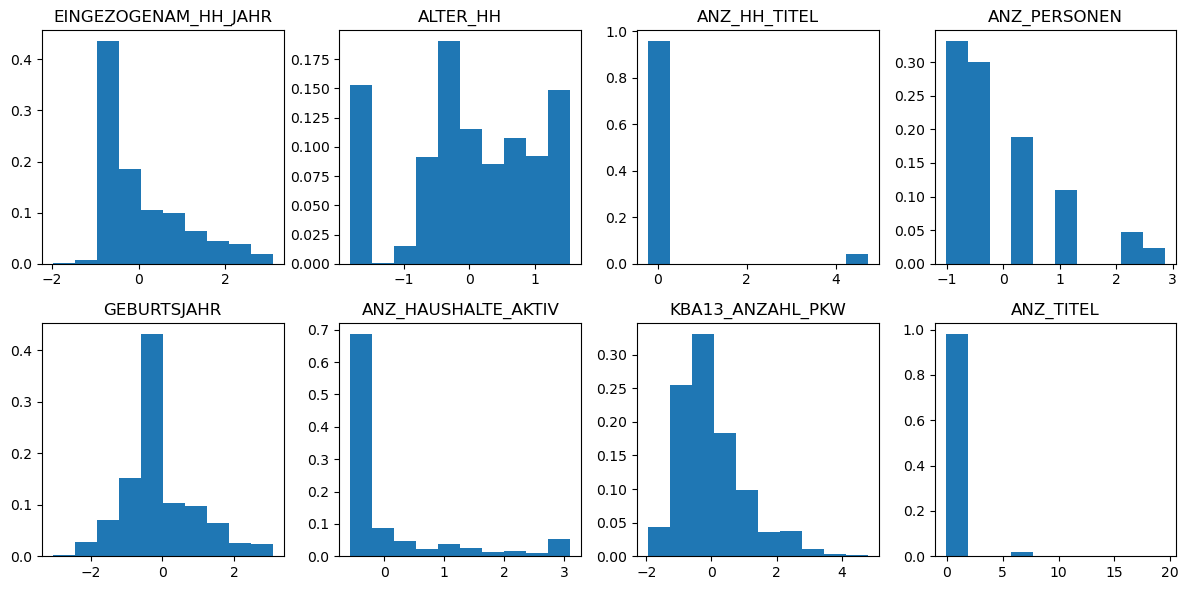

In [170]:
# Calculate the dimensions of the subplots based on the number of columns
dataset = small_customers

columns = list(c_num.intersection(dataset.columns))
num_columns = len(columns)
print(num_columns)
num_rows = 3
if num_columns > 4:
    num_rows = num_columns // 5 + (num_columns % 5 > 0)

# Create the subplots
fig, axes = plt.subplots(num_rows, 4, figsize=(12, 3 * num_rows))

# Flatten the axes if necessary
if num_rows > 1:
    axes = axes.flatten()

# Iterate over the columns and create the bin charts
for i, col in enumerate(columns):
    ax = axes[i]
    # from https://stackoverflow.com/questions/9767241/setting-a-relative-frequency-in-a-matplotlib-histogram
    n, bins, _  = ax.hist(dataset[col], weights=np.zeros_like(dataset[col]) + 1. / dataset[col].size)
    ax.set_title(col)

fig.tight_layout()
plt.savefig('num_graph.png')
plt.show()

### Part 1: Customer Segmentation Report
The main bulk of your analysis will come in this part of the project. Here, you should use unsupervised learning techniques to describe the relationship between the demographics of the company's existing customers and the general population of Germany. By the end of this part, you should be able to describe parts of the general population that are more likely to be part of the mail-order company's main customer base, and which parts of the general population are less so.

#### Part 1.0a Preparing data
Involves standardizing and drawing a sample. 

In [84]:
# Only necessary if the small dataset are not yet available! 
customers = pd.read_csv('data/custom_new.csv', sep=',')
customers = setting_types(daten = customers)
azdias = pd.read_csv('data/azdias_new.csv', sep=',', low_memory = False)
azdias = setting_types(daten = azdias)

In [40]:
# We standardize the numeric values. 
def standardizing_numeric(dataset):
    #https://stackoverflow.com/questions/26414913/normalize-columns-of-a-dataframe
    dataset=(dataset-dataset.mean())/dataset.std()
    return dataset


def standardize_ordinal(dataset):
    # from The Elements of Statistical Learning by Trevor Hastie, Robert Tibshirani, Jerome Friedman, p.504
    for c in dataset.columns:
        c_max = dataset[c].max()
        dataset[c] = (dataset[c] - 0.5) / c_max
    return dataset


In [87]:
num_cols = list(c_num.intersection(azdias.columns))
azdias[num_cols] = standardizing_numeric(azdias[num_cols])
ord_cols = list(c_ord.intersection(azdias.columns))
azdias[ord_cols] = standardize_ordinal(dataset = azdias[ord_cols])

In [41]:
num_cols = list(c_num.intersection(customers.columns))
customers[num_cols] = standardizing_numeric(customers[num_cols])
ord_cols = list(c_ord.intersection(customers.columns))
customers[ord_cols] = standardize_ordinal(dataset = customers[ord_cols])

In [88]:
def drawing_sample(input, output_name, size):
    sample_size = int(len(input) * size)
    output = input.sample(n=sample_size, random_state = 17)
    exporting(output, 'data/{}.csv'.format(output_name))
    return output


In [102]:
#small_customers = drawing_sample(input = customers, output_name = 'small_custom', size = 0.15)
small_azdias = drawing_sample(input = azdias, output_name = 'small_azdias', size = 0.05)

#### Part 1.0b Importing small dataset

In [10]:
# Importing small dataset
small_customers = pd.read_csv('data/custom_small.csv', sep=',')
c_all, c_num, c_cat, c_ord = defining_types(small_customers)
small_customers = setting_types(daten = small_customers)
small_customers.shape

C:\Users\TAMM\AppData\Local\Temp\ipykernel_7420\3985666160.py:2: DtypeWarning: Columns (279) have mixed types. Specify dtype option on import or set low_memory=False.
  small_customers = pd.read_csv('data/custom_small.csv', sep=',')


We will remove 0 variables.
set()


(21128, 342)

In [45]:
small_azdias = pd.read_csv('data/azdias_small.csv', sep=',')
small_azdias = setting_types(daten = small_azdias)
small_azdias.shape

C:\Users\TAMM\AppData\Local\Temp\ipykernel_7420\2047993647.py:1: DtypeWarning: Columns (278) have mixed types. Specify dtype option on import or set low_memory=False.
  small_azdias = pd.read_csv('data/azdias_small.csv', sep=',')


(39555, 341)

#### 1.1 Reducing dimensions

In [94]:
def pca_model(data, components):
    # From https://stackoverflow.com/questions/32857029/python-scikit-learn-pca-explained-variance-ratio-cutoff
    my_model = PCA(n_components=components)
    my_model_fit = my_model.fit_transform(data)
    var_explained = np.fromstring(str(my_model.explained_variance_ratio_.cumsum())[1:-1], sep=' ')
    return my_model, my_model_fit, var_explained


In [63]:
def mca_model(data):
    # From https://stackoverflow.com/questions/32857029/python-scikit-learn-pca-explained-variance-ratio-cutoff
    my_model = MCA()
    my_model.fit(data)
    new_data = my_model.transform(data)
    return new_data, my_model


In [45]:
# Customers: Run pca and mca
customers_num = small_customers.select_dtypes(include=['float'])
print(customers_num.shape)
cust_model, cust_model_fit, cust_var_expl = pca_model(data = customers_num, components = 10)
print(cust_var_expl)
new_cust_num = pd.DataFrame(cust_model.transform(customers_num))

# initially I went with 50 (explaining 78% of variance), but I could not find sensible clusters then. 
# trying with 10 (explaining 50%)

new_cust_obj, cust_mca_model = mca_model(small_customers.select_dtypes(include=['object']))
new_cust_obj.shape


(21128, 291)
[0.11385283 0.19437199 0.26939884 0.32179454 0.36641877 0.40893959
 0.44019954 0.46808757 0.48883187 0.50860297]


In [103]:

# Azdias: Run pca and mca
azdias_num = small_azdias.select_dtypes(include=['float'])
print(azdias_num.shape)
azdi_model, azdi_model_fit, azdi_var_expl = pca_model(data = azdias_num, components = 10)
print(azdi_var_expl)
new_azdi_num = pd.DataFrame(azdi_model.transform(azdias_num))

new_azdi_obj, azdi_mca_model = mca_model(small_azdias.select_dtypes(include=['object']))
new_azdi_obj.shape

(39555, 291)
[0.10991846 0.19001653 0.24867649 0.30391426 0.34844513 0.38745788
 0.42346217 0.45081403 0.47808224 0.49934245]


c:\Users\TAMM\anaconda3\lib\site-packages\prince\mca.py:30: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  one_hot = pd.get_dummies(X, columns=X.columns)
c:\Users\TAMM\anaconda3\lib\site-packages\prince\mca.py:30: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  one_hot = pd.get_dummies(X, columns=X.columns)
c:\Users\TAMM\anaconda3\lib\site-packages\prince\mca.py:30: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  one_hot = pd.get_dummies(X, columns=X.columns)
c:\Users\TAMM\anaconda3\lib\site-packages\prince\mca.py:30: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  one_hot = p

(39555, 2)

#### Part 1.2 Estimating Clusters

In [46]:
def elbow_method(data, max_clusters):
    
    #https://predictivehacks.com/k-means-elbow-method-code-for-python/
    inertia_values = []

    for num_clusters in range(1, max_clusters + 1):
        kmeans = KMeans(n_clusters=num_clusters)
        kmeans.fit(data)
        inertia_values.append(kmeans.inertia_)

    # Plotting the Elbow curve
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, max_clusters + 1), inertia_values, marker='o')
    plt.xlabel('Number of Clusters')
    plt.ylabel('Within-Cluster Sum of Squares (Inertia)')
    plt.title('Elbow Method for Optimal Number of Clusters')
    plt.xticks(np.arange(1, max_clusters + 1, 1))
    plt.grid(True)
    plt.show()

def cluster_kmeans(data, num_clusters):
    # Create a KMeans object with the desired number of clusters (e.g., 3 clusters)
    kmeans = KMeans(n_clusters=num_clusters)

    # Fit the KMeans model and get the cluster assignments for each observation
    cluster_assignments = kmeans.fit_predict(data)

    # Add the cluster assignments as a new column to original DataFrame
    data['Cluster'] = cluster_assignments
    print(np.unique(cluster_assignments, return_counts = True))

    pass 



c:\Users\TAMM\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


c:\Users\TAMM\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\TAMM\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\TAMM\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\TAMM\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\TAMM\anaconda3\lib\site-packages\sklearn\cluster\_k

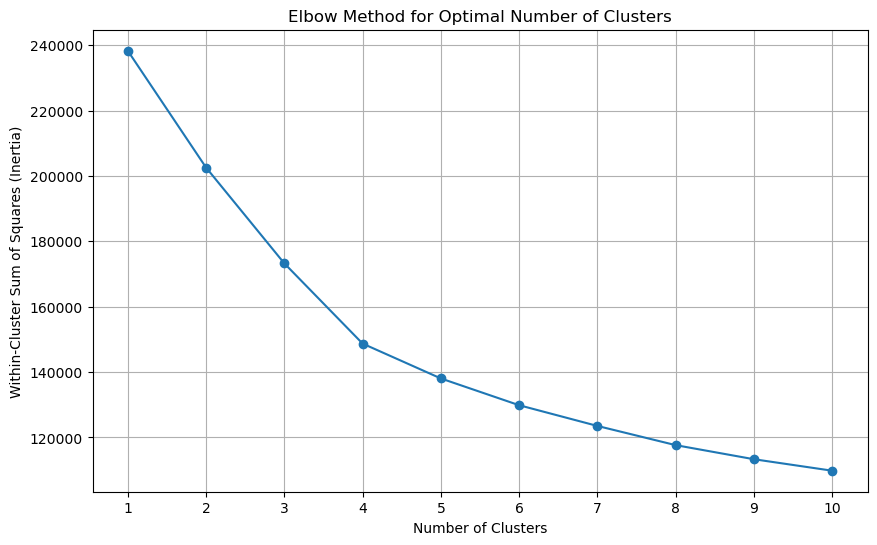

In [48]:
elbow_method(data = new_cust_num, max_clusters = 10)

In [179]:
cluster_kmeans(data = new_cust_num.drop(columns = 'Cluster'), num_clusters = 4)

c:\Users\TAMM\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


(array([0, 1, 2, 3]), array([9688,  409, 7077, 3954], dtype=int64))


c:\Users\TAMM\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\TAMM\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\TAMM\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\TAMM\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\TAMM\anaconda3\lib\site-packages\sklearn\cluster\_k

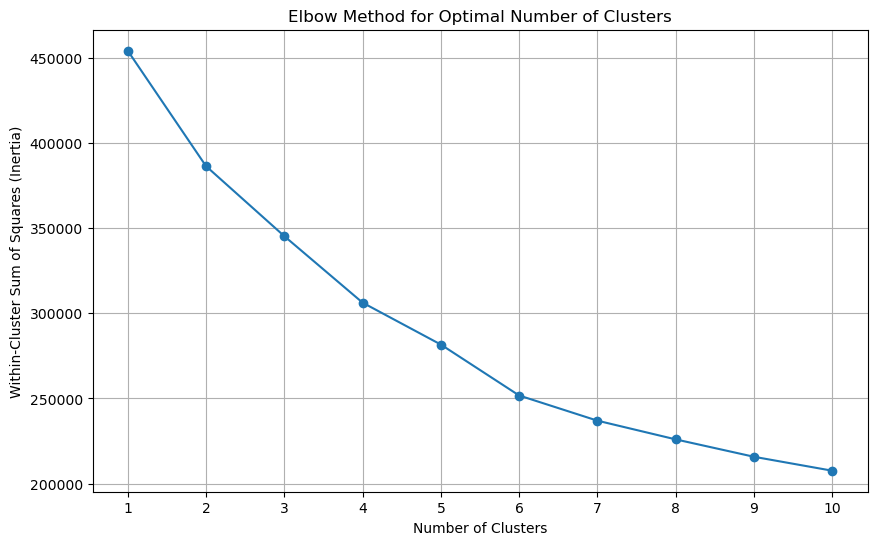

In [104]:
elbow_method(data = new_azdi_num, max_clusters = 10)

In [180]:
cluster_kmeans(data = new_azdi_num.drop(columns = 'Cluster'), num_clusters = 4)

c:\Users\TAMM\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


(array([0, 1, 2, 3]), array([12309, 10268,  1169, 15809], dtype=int64))


In [49]:
def dbscan_clustering(data, eps = 0.5, min_samples = 5):
    """
    Input:
    data: data used for clustering
    eps: key parameter in clustering 
    min-samples: key parameter in clustering
    
    Output:
    Adds the cluster assignments as a new column to data
    Prints the number of clusters found
    """
    dbscan = DBSCAN(eps=eps, min_samples=min_samples)
    cluster_assignments = dbscan.fit_predict(data)
    data['Cluster'] = cluster_assignments
    num_clusters = len(np.unique(cluster_assignments)) - 1
    print(f"Number of clusters found: {num_clusters}")
    print(data['Cluster'].value_counts())


In [59]:
dbscan_clustering(data = new_cust_num.drop(columns = 'Cluster'), eps = 0.8, min_samples = 20)
# dbscan found 9 with eps = 0.5, n=50 and min_sample = 2
# but 0 when min_sample > 2
# now trying with n = 10 and min_sample = 2 --> 873
# min_sample = 5 --> 34
# min_sample = 10 --> 3
# but most values were not put into a cluster
# eps = 0.8 and min_sample = 20 --> 3
# but still 17500 of 21000 not in a cluster
# I clipped two metric variables to have 99 and 95 percentile as max.
# eps = 0.8, min_sample = 20 --> 8 with 19500 -1. 

Number of clusters found: 8
-1    19519
 0     1266
 1      181
 3       63
 4       24
 2       21
 5       20
 6       17
 7       17
Name: Cluster, dtype: int64


In [105]:
dbscan_clustering(data = new_azdi_num, eps = 0.8, min_samples = 37) 
# dbscan found 1 cluster with eps = 0.5, n=50 and min_sample = 2 
# with n = 10 and min_sample = 2 --> 2107 clusters 
# min_sample = 5 --> 118 
# min_sample = 10 --> 17 
# min_sample = 20 --> 1 
# min_sample = 15 --> 7 
# min_sample = 18 --> 3 
# I think min_sample = 18 is reasonable because the dataset is almost twice the size of customers. 

Number of clusters found: 4
-1    34875
 0     3672
 1      769
 2      218
 3       21
Name: Cluster, dtype: int64


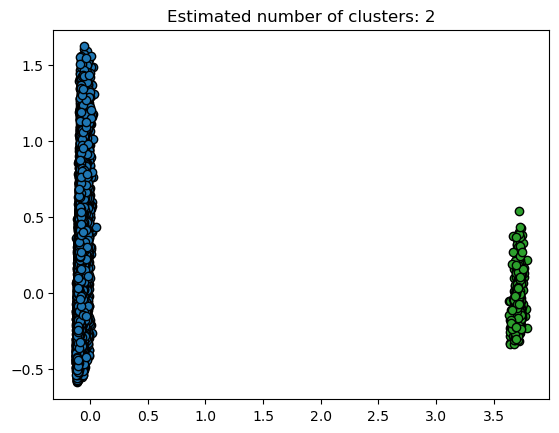

In [173]:
def DBSCAN_plotting(data, eps, min_samples):
    #https://scikit-learn.org/stable/auto_examples/cluster/plot_dbscan.html#sphx-glr-auto-examples-cluster-plot-dbscan-py
    
    # Initialize and fit DBSCAN
    db = DBSCAN(eps=eps, min_samples=min_samples)
    db.fit(data)

    # Create a scatter plot for the clusters
    core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
    core_samples_mask[db.core_sample_indices_] = True
    labels = db.labels_

    # Number of clusters in labels, ignoring noise if present.
    n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
    
    # Plot the points
    unique_labels = set(labels)
    colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]
    for k, col in zip(unique_labels, colors):
        if k == -1:
            # Black used for noise.
            col = [0, 0, 0, 1]

        class_member_mask = (labels == k)

        xy = data[class_member_mask & core_samples_mask].values
        plt.plot(xy[:, 0], xy[:, 1], 'o', markeredgecolor='k', markersize=6)

        xy = data[class_member_mask & ~core_samples_mask].values
        plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col), markeredgecolor='k', markersize=4)

    plt.title(f'Estimated number of clusters: {n_clusters_}')
    plt.show()


DBSCAN_plotting(data = new_cust_obj, eps = 0.5, min_samples = 5)

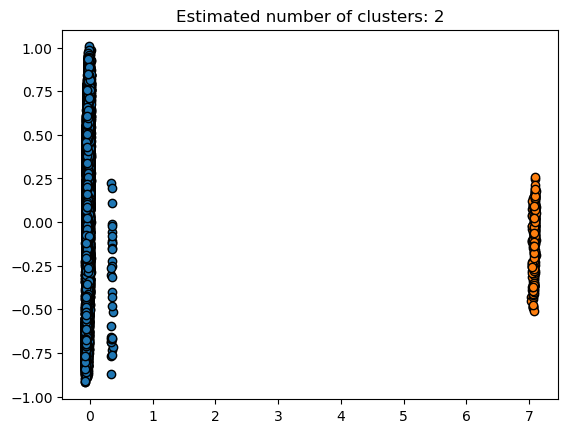

In [106]:

DBSCAN_plotting(data = new_azdi_obj, eps = 0.5, min_samples = 5)

In [115]:
#new_azdi_obj.describe()

#new_azdi_obj.columns
new_azdi_obj[new_azdi_obj.iloc[:,0] > 5]

,0,1
615273,7.067216,-0.339930
13955,7.083004,0.041425
51745,7.101999,-0.186849
588669,7.080676,-0.127027
170435,7.089039,0.173852
...,...,...
123042,7.081630,0.090303
201387,7.080474,-0.139899
25479,7.062913,-0.371430
452828,7.080639,0.022762


We create a density plot for the numeric variables (only showing 2). This loses a lot of the variance, but we do it anyway. 

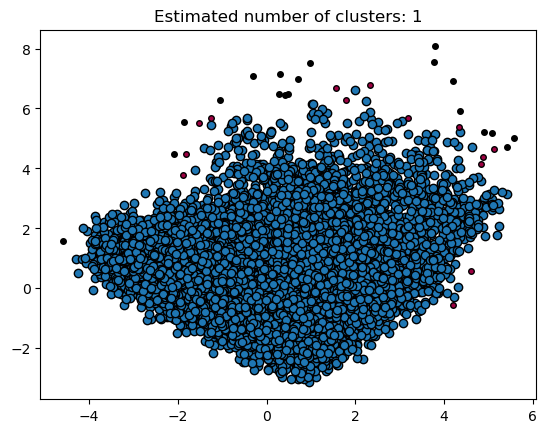

In [187]:
cust_model_2, cust_model_fit_2, cust_var_expl_2 = pca_model(data = customers_num, components = 2)
DBSCAN_plotting(data = pd.DataFrame(cust_model_fit_2), eps = 0.5, min_samples = 5)


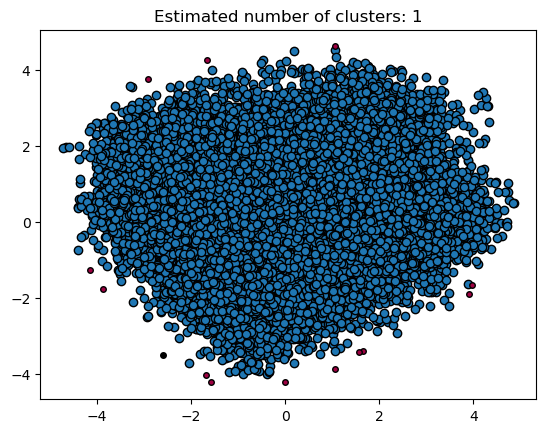

In [188]:
azdi_model_2, azdi_model_fit_2, azdi_var_expl_2 = pca_model(data = azdias_num, components = 2)
DBSCAN_plotting(data = pd.DataFrame(azdi_model_fit_2), eps = 0.5, min_samples = 5)

### Part 2: Supervised Learning Model
Now that you've found which parts of the population are more likely to be customers of the mail-order company, it's time to build a prediction model. Each of the rows in the "MAILOUT" data files represents an individual that was targeted for a mailout campaign. Ideally, we should be able to use the demographic information from each individual to decide whether or not it will be worth it to include that person in the campaign.

The "MAILOUT" data has been split into two approximately equal parts, each with almost 43 000 data rows. In this part, you can verify your model with the "TRAIN" partition, which includes a column, "RESPONSE", that states whether or not a person became a customer of the company following the campaign. In the next part, you'll need to create predictions on the "TEST" partition, where the "RESPONSE" column has been withheld.

In [ ]:
mailout_train = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_MAILOUT_052018_TRAIN.csv', sep=';')

### Trail and Error

In [ ]:
#https://towardsdatascience.com/clustering-on-numerical-and-categorical-features-6e0ebcf1cbad


import pandas as pd

# Creating a dictionary with the data
dictionary = {"age": [22, 25, 30, 38, 42, 47, 55, 62, 61, 90], 
              "gender": ["M", "M", "F", "F", "F", "M", "M", "M", "M", "M"], 
              "civil_status": ["SINGLE", "SINGLE", "SINGLE", "MARRIED", "MARRIED", "SINGLE", "MARRIED", "DIVORCED", "MARRIED", "DIVORCED"], 
              "salary": [18000, 23000, 27000, 32000, 34000, 20000, 40000, 42000, 25000, 70000], 
              "has_children": [False, False, False, True, True, False, False, False, False, True], 
              "purchaser_type": ["LOW_PURCHASER", "LOW_PURCHASER", "LOW_PURCHASER", "HEAVY_PURCHASER", "HEAVY_PURCHASER", "LOW_PURCHASER", "MEDIUM_PURCHASER", "MEDIUM_PURCHASER", "MEDIUM_PURCHASER", "LOW_PURCHASER"]}

# Creating a Pandas DataFrame from the dictionary
dataframe = pd.DataFrame.from_dict(dictionary)

distance_matrix = gower.gower_matrix(dataframe)


# Configuring the parameters of the clustering algorithm
dbscan_cluster = DBSCAN(eps=0.3, 
                        min_samples=2, 
                        metric="precomputed")

# Fitting the clustering algorithm
dbscan_cluster.fit(distance_matrix)

# Adding the results to a new column in the dataframe
dataframe["cluster"] = dbscan_cluster.labels_
dataframe["cluster"]

In [ ]:

# this does take too much time. 
#distance_matrix = gower.gower_matrix(new_cust)

In [ ]:
"""
A failed try with random projection 
#target_dimension = customers_num.shape[1] // 2
for n in range(40,330, 20): 
    rp = random_projection.SparseRandomProjection(n_components = n)
    cust_num_new = rp.fit_transform(customers_num)
    print(cust_num_new.shape)
    # Calculate the number of samples and original dimensionality
    num_samples, original_dimension = customers_num.shape

    # Choose the target dimension after random projection
    target_dimension = cust_num_new.shape[1]

    # Calculate the Johnson-Lindenstrauss (JL) bound for the distortion
    JL_bound = np.sqrt(0.1 * original_dimension / target_dimension)
    
    information_lost_percentage = (1 - JL_bound) * 100

    print('with {} features the JL_bound is:'.format(n), JL_bound)
"""

In [ ]:
# I tried to check how much variance is kept when reducing from 51 to 2 for obj and the numbers for the complete dataset. However, I failed.

"""
categorical_column_variances = np.sum(mca.eigenvalues_)

original_numeric_variance = np.sum(my_model.explained_variance_)
combined_reduced_variance = np.sum(my_model.explained_variance_) + categorical_column_variances

# Step 3: Calculate the percentage of variance retained
variance_retained = (combined_reduced_variance / (original_numeric_variance + categorical_column_variances)) * 100

print(f"Percentage of Variance Retained: {variance_retained:.2f}%")




#original_numeric_variance = customers_num.var().sum()
#original_cateorical_variance = customers_obj.var().sum()
#print(original_numeric_variance, original_cateorical_variance)
#new_numeric_variance = new_cust_num.var().sum()
#new_object_variance = new_cust_obj.var().sum()
#print(new_numeric_variance, new_object_variance)

#print(new_numeric_variance/original_numeric_variance)
#categorical_column_variances = mca.eigenvalues_.sum()
#print(categorical_column_variances)

# Step 1: Calculate the total variance of the original numeric dataset
original_numeric_variance = customers_num.var().sum()


# Step 2: Calculate the variance of the original categorical dataset using MCA eigenvalues
mca = MCA()
mca.fit(customers_obj)
categorical_column_variances_original = mca.eigenvalues_.sum()

# Step 3: Calculate the total variance of the combined reduced dataset
combined_reduced_df = pd.concat([new_cust_num, new_cust_obj], axis=1)

# Step 4: Calculate the variance of the reduced categorical dataset using MCA eigenvalues
mca_reduced = MCA()
mca_reduced.fit(new_cust_obj)
categorical_column_variances_reduced = mca_reduced.eigenvalues_.sum()

combined_reduced_variance = reduced_numeric_df.var().sum() + categorical_column_variances_reduced

# Step 5: Calculate the percentage of variance retained
variance_retained = (combined_reduced_variance / (original_numeric_variance + categorical_column_variances_original)) * 100

print(variance_retained)
"""